# Example notebook to apply bias adjustment techniques 

In [1]:
import numpy as np
import xarray as xr
import random
import matplotlib.pyplot as plt

np.random.seed(0)
random.seed(0)

# Define some functions 

In [2]:
historical_time = xr.cftime_range("1971-01-01", "2000-12-31", freq="D", calendar="noleap")
future_time = xr.cftime_range("2001-01-01", "2030-12-31", freq="D", calendar="noleap")

get_hist_temp_for_lat = lambda val: 273.15 - (val * np.cos(2 * np.pi * historical_time.dayofyear / 365) + 2 * np.random.random_sample((historical_time.size,)) + 273.15 + .1 * (historical_time - historical_time[0]).days / 365)
get_rand = lambda: np.random.rand() if np.random.rand() > .5 else  -np.random.rand()

In [3]:
latitudes = np.arange(23,27,1)
some_data = [get_hist_temp_for_lat(val) for val in latitudes]
data = np.array([some_data, np.array(some_data)+1])

# Create dummy data

In [4]:
attrs = {"units": "°C"}

In [5]:
obsh = xr.DataArray(
    data,
    dims=("lon", "lat", "time"),
    coords={"time": historical_time, "lat": latitudes, "lon": [0,1]},
    attrs=attrs
).transpose("time","lat","lon").to_dataset(name="tas")#.to_netcdf("observations.nc", )

simh = xr.DataArray(
    data-2,
    dims=("lon", "lat", "time"),
    coords={"time": historical_time, "lat": latitudes, "lon": [0,1]},
    attrs=attrs
).transpose("time","lat","lon").to_dataset(name="tas")#.to_netcdf("control.nc", )

simp = xr.DataArray(
    data-1,
    dims=("lon", "lat", "time"),
    coords={"time": future_time, "lat": latitudes, "lon": [0,1]},
    attrs=attrs
).transpose("time","lat","lon").to_dataset(name="tas")#.to_netcdf("scenario.nc", )

obsp = xr.DataArray(
    data+1,
    dims=("lon", "lat", "time"),
    coords={"time": historical_time, "lat": latitudes, "lon": [0,1]},
    attrs=attrs
).transpose("time","lat","lon").to_dataset(name="tas")#.to_netcdf("observations_future.nc")

# Plot created toy data

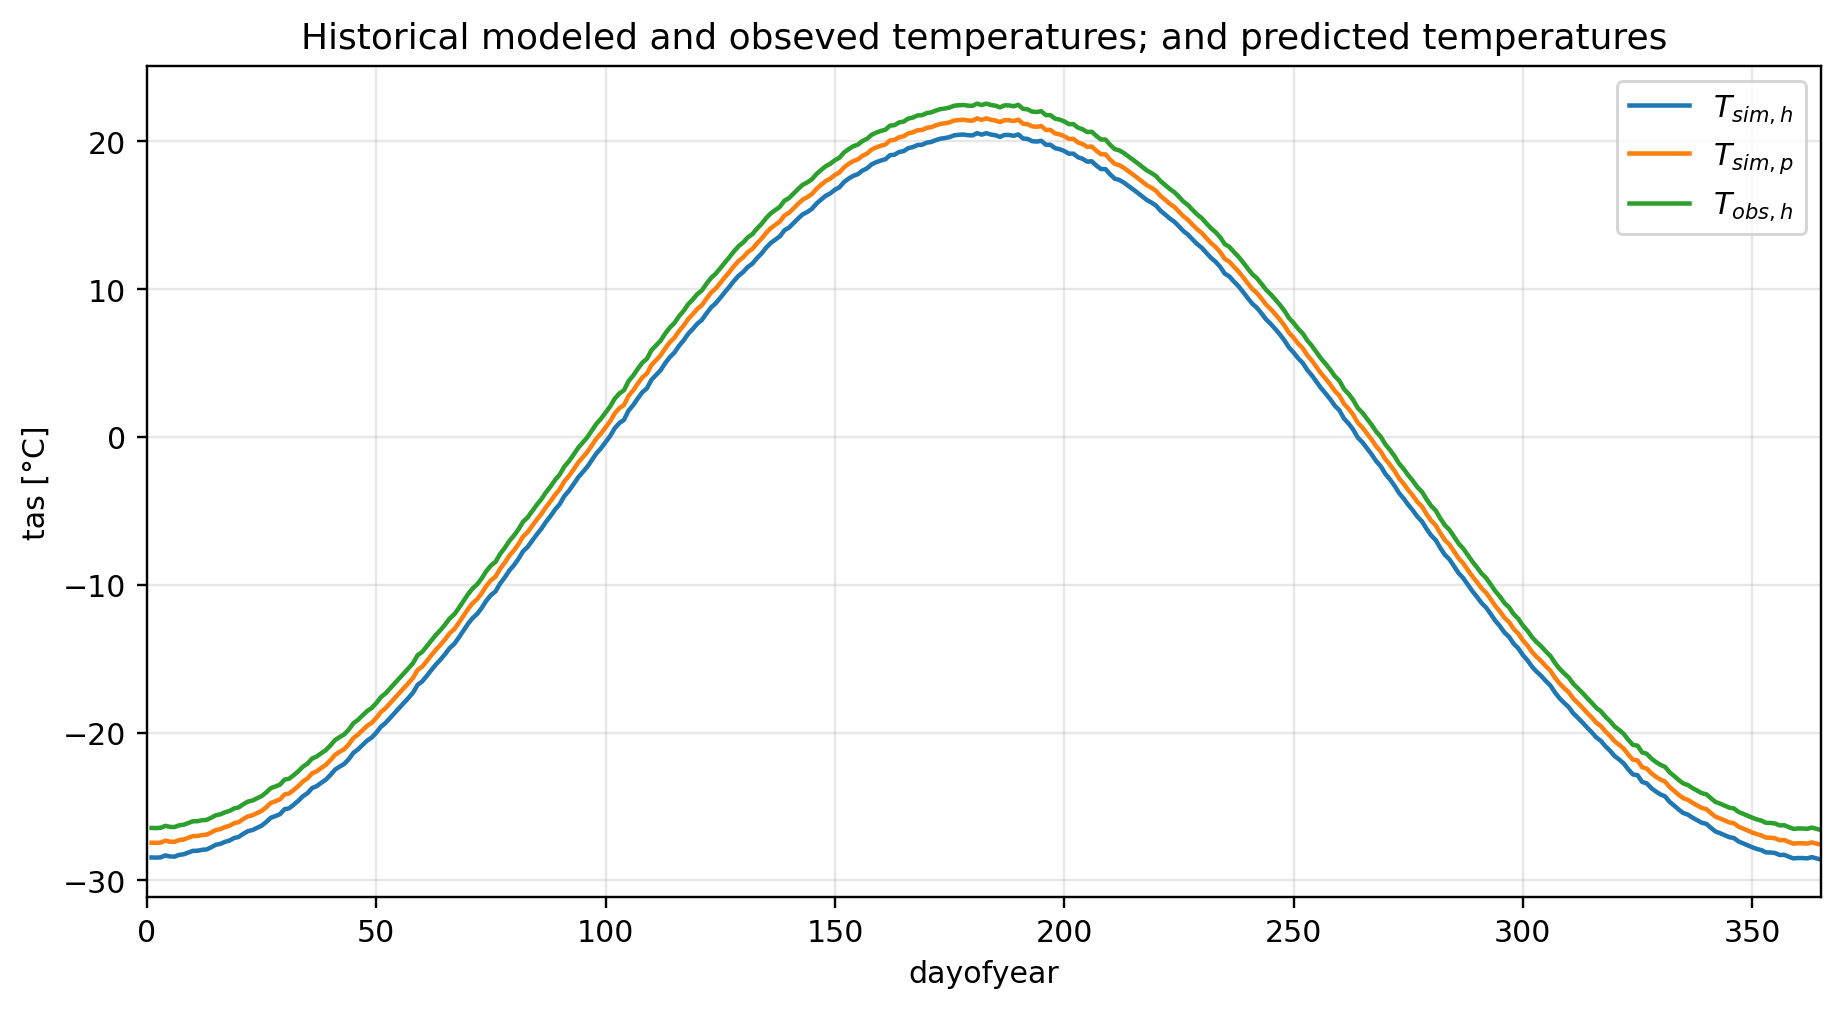

In [6]:
plt.figure(figsize=(10,5),dpi=216)
simh["tas"].groupby("time.dayofyear").mean(...).plot(label="$T_{sim,h}$")
simp["tas"].groupby("time.dayofyear").mean(...).plot(label="$T_{sim,p}$")
obsh["tas"].groupby("time.dayofyear").mean(...).plot(label="$T_{obs,h}$")
plt.title("Historical modeled and obseved temperatures; and predicted temperatures")
plt.xlim(0,365)
plt.gca().grid(alpha=.3)
plt.legend();

* Modeled historical temperatures are to warm in comparison to the observed temperatures.

# Import module to adjust the data

In [7]:
from cmethods import CMethods as cm

## Apply QDM adjustment

In [8]:
# to adjust a 3d dataset
qdm_result = cm.adjust_3d(
    method = "quantile_delta_mapping",
    obs = obsh["tas"],
    simh = simh["tas"],
    simp = simp["tas"],
    n_quaniles = 1000,
    kind = "+", # to calculate the relative rather than the absolute change, "*" can be used instead of "+" (this is prefered when adjusting precipitation)
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.67it/s]


In [9]:
qdm_result

<xarray.DataArray 'tas' (time: 10950, lat: 4, lon: 2)>
array([[[-23.10136938, -22.10136938],
        [-24.44140058, -23.44140058],
        [-26.01662437, -25.01662437],
        [-26.28269982, -25.28269982]],

       [[-23.41589465, -22.41589465],
        [-24.56309161, -23.56309161],
        [-24.04938832, -23.04938832],
        [-26.01993313, -25.01993313]],

       [[-23.18047936, -22.18047936],
        [-24.61759495, -23.61759495],
        [-24.38520952, -23.38520952],
        [-25.59637237, -24.59637237]],

       ...,

       [[-25.56795121, -24.56795121],
        [-26.43865472, -25.43865472],
        [-28.31595975, -27.31595975],
        [-29.04694175, -28.04694175]],

       [[-26.37948592, -25.37948592],
        [-27.46839831, -26.46839831],
        [-28.41172919, -27.41172919],
        [-29.84433331, -28.84433331]],

       [[-25.65145194, -24.65145194],
        [-28.06217378, -27.06217378],
        [-28.43720573, -27.43720573],
        [-29.98579602, -28.98579602]]])
Coordinates:
  * time     (time) object 2001-01-01 00:00:00 ... 2030-12-31 00:00:00
  * lat      (lat) int64 23 24 25 26
  * lon      (lon) int64 0 1
Attributes:
    units:    °C

## Visualize QDM result

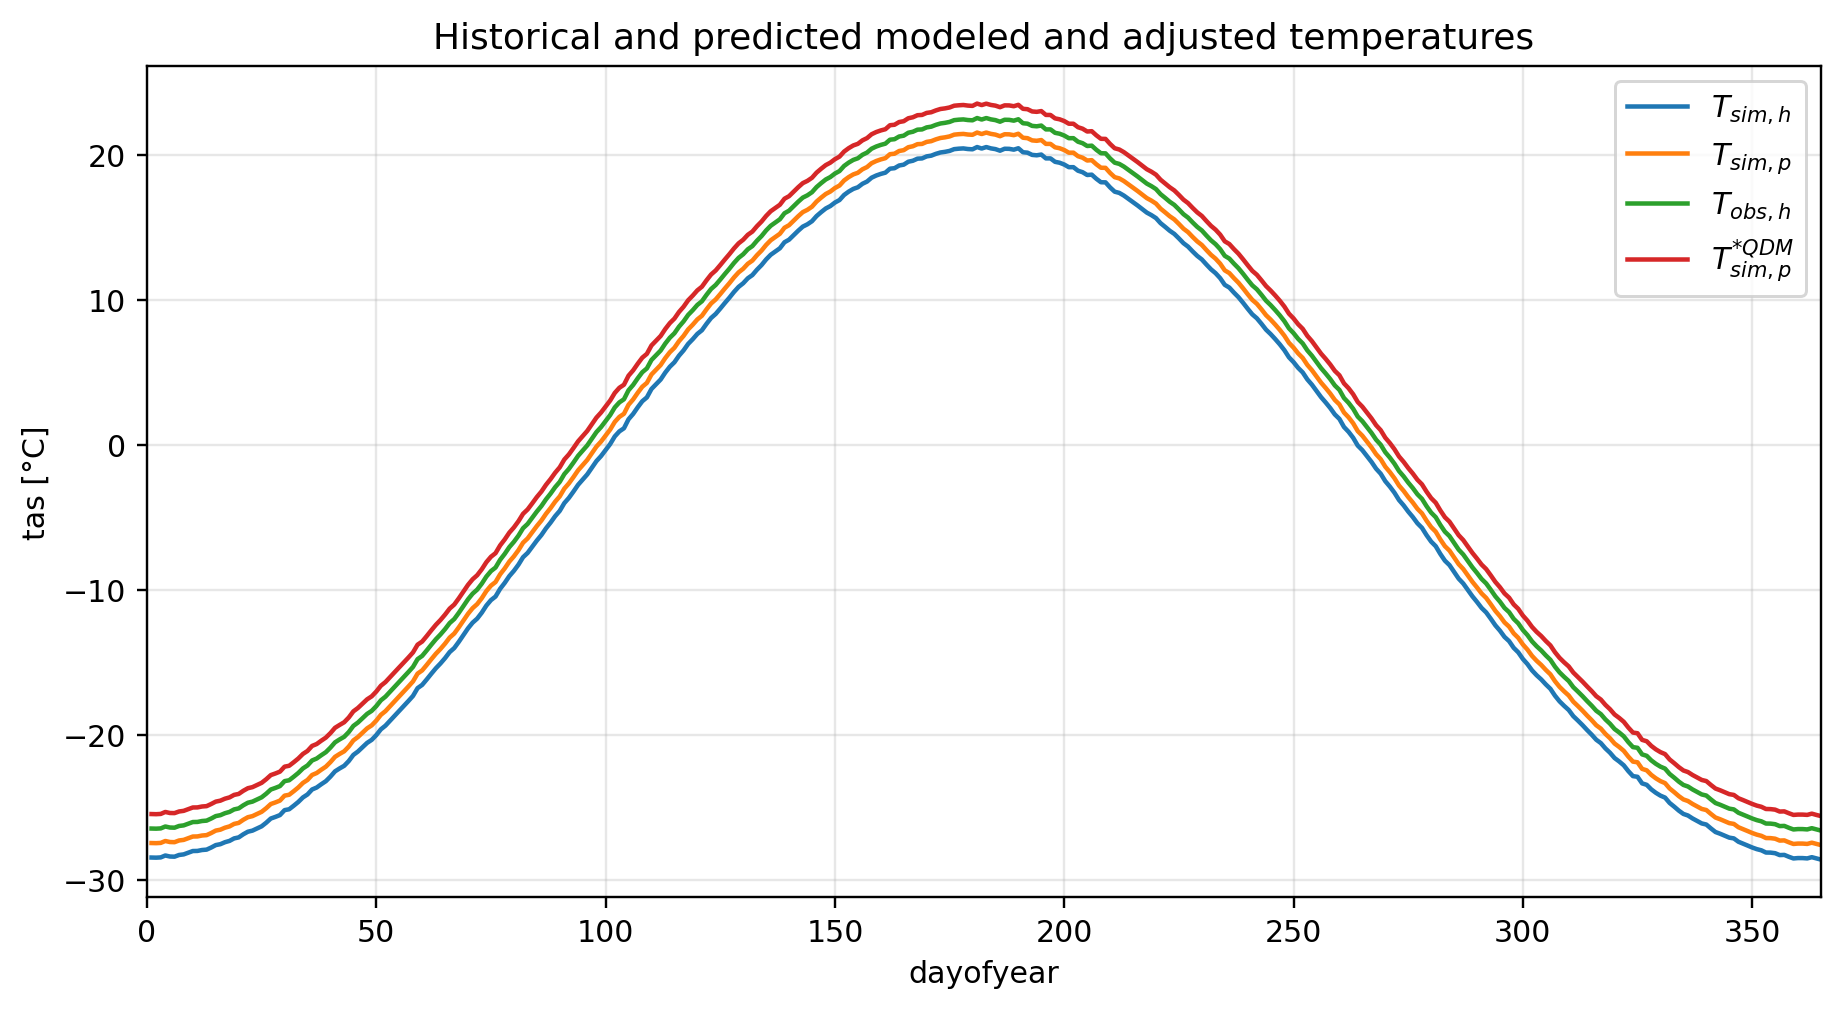

In [10]:
plt.figure(figsize=(10,5),dpi=216)
simh["tas"].groupby("time.dayofyear").mean(...).plot(label="$T_{sim,h}$")
simp["tas"].groupby("time.dayofyear").mean(...).plot(label="$T_{sim,p}$")
obsh["tas"].groupby("time.dayofyear").mean(...).plot(label="$T_{obs,h}$")
qdm_result.groupby("time.dayofyear").mean(...).plot(label="$T^{*QDM}_{sim,p}$")
plt.title("Historical and predicted modeled and adjusted temperatures")
plt.xlim(0,365)
plt.gca().grid(alpha=.3)
plt.legend();

* After the adjustment, the predicted temperatures got warmer ($\mu T^{*QDM}_{sim,p} > \mu T_{sim,p}$)

In [11]:
ls_result = cm.adjust_3d(
    method="linear_scaling",
    obs=obsh["tas"],
    simh=simh["tas"],
    simp=simp["tas"],
    group="time.month",
    kind="+"
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:04<00:00, 16.07s/it]


In [12]:
vs_result = cm.adjust_3d(
    method="variance_scaling",
    obs=obsh["tas"],
    simh=simh["tas"],
    simp=simp["tas"],
    group="time.month",
    kind = "+"
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:15<00:00, 18.78s/it]


In [13]:
dm_result = cm.adjust_3d(
    method="delta_method",
    obs=obsh["tas"],
    simh=simh["tas"],
    simp=simp["tas"],
    group="time.month",
    kind="+"
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:11<00:00, 17.90s/it]


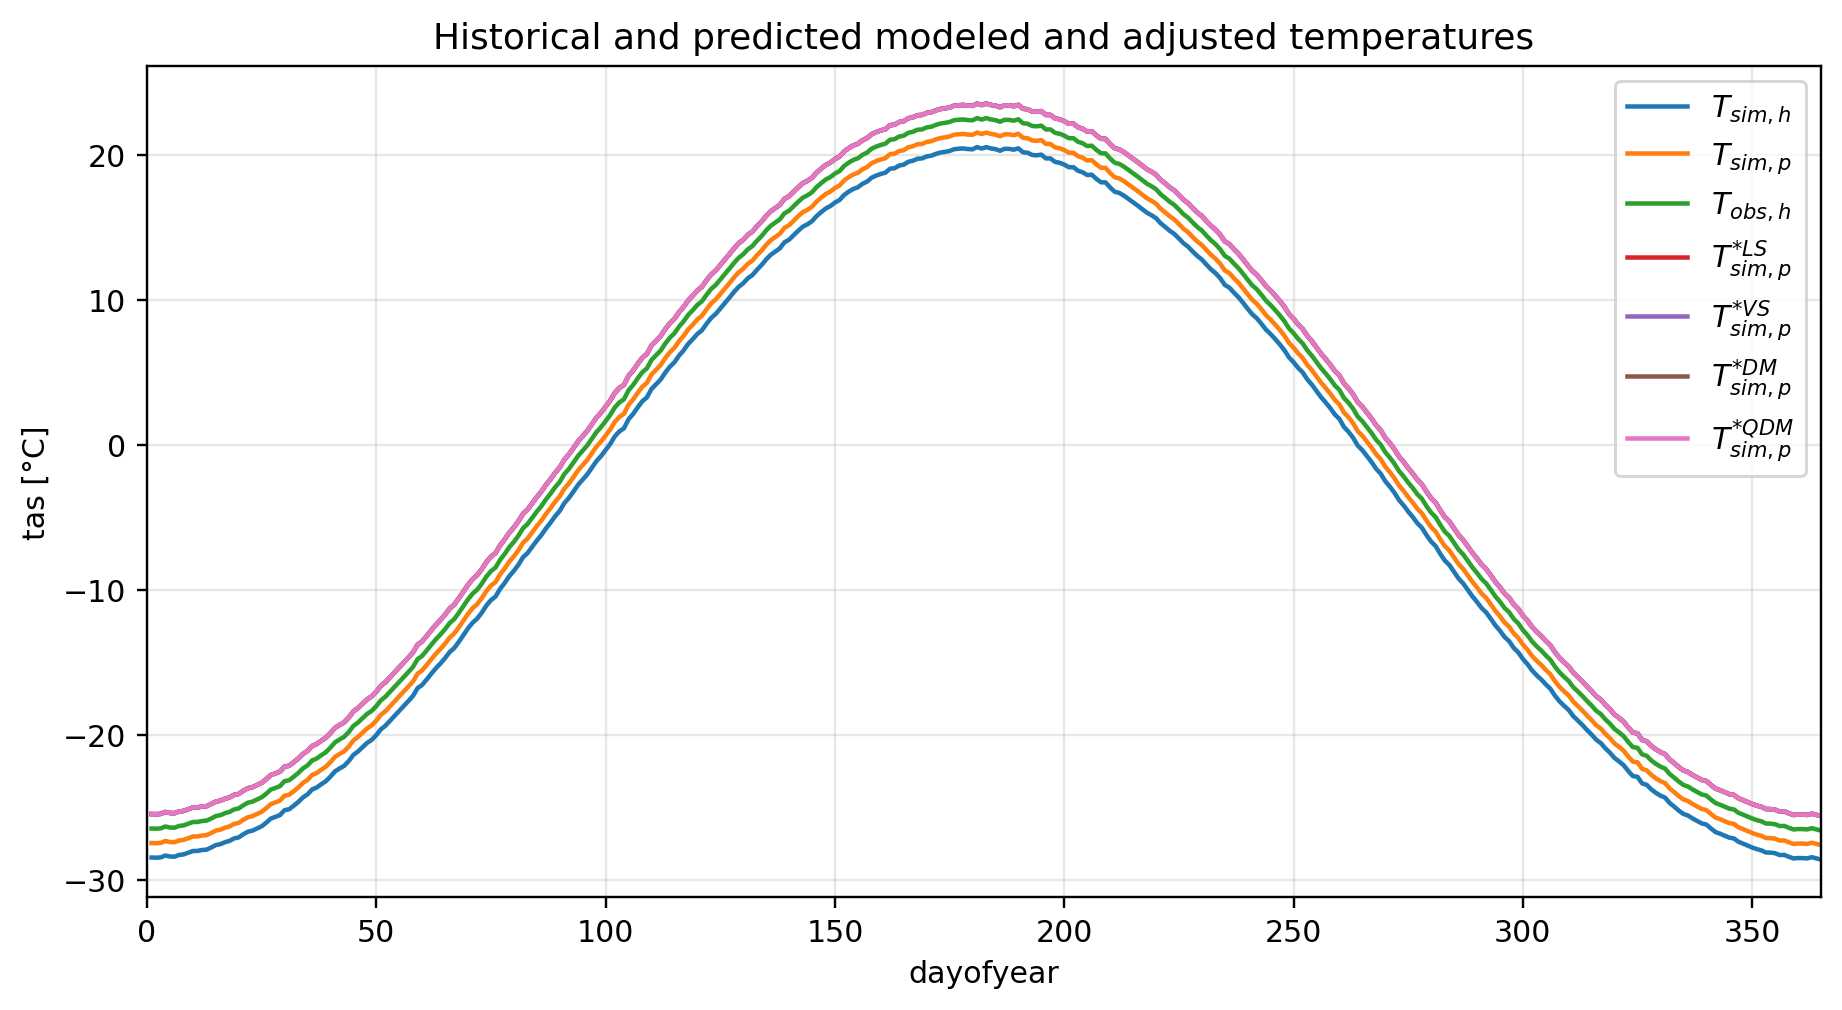

In [14]:
plt.figure(figsize=(10,5),dpi=216)
simh["tas"].groupby("time.dayofyear").mean(...).plot(label="$T_{sim,h}$")
simp["tas"].groupby("time.dayofyear").mean(...).plot(label="$T_{sim,p}$")
obsh["tas"].groupby("time.dayofyear").mean(...).plot(label="$T_{obs,h}$")
ls_result.groupby("time.dayofyear").mean(...).plot(label="$T^{*LS}_{sim,p}$")
vs_result.groupby("time.dayofyear").mean(...).plot(label="$T^{*VS}_{sim,p}$")
dm_result.groupby("time.dayofyear").mean(...).plot(label="$T^{*DM}_{sim,p}$")
qdm_result.groupby("time.dayofyear").mean(...).plot(label="$T^{*QDM}_{sim,p}$")
plt.title("Historical and predicted modeled and adjusted temperatures")
plt.xlim(0,365)
plt.gca().grid(alpha=.3)
plt.legend();

(... because of dummy data - all adjusted datasets seem to have the same result)

It is also possible to adjust individual time series:

In [15]:
ls_result = cm.linear_scaling(
    obs=obsh["tas"].sel(lat=23, lon=0, method="nearest"),
    simh=simh["tas"].sel(lat=23, lon=0, method="nearest"),
    simp=simp["tas"].sel(lat=23, lon=0, method="nearest"),
    kind="+",
    group="time.month"
)

In [16]:
ls_result

<xarray.DataArray 'tas' (time: 10950)>
array([-23.09421931, -23.41702292, -23.17541147, ..., -25.57722903,
       -26.33119336, -25.63539539])
Coordinates:
  * time     (time) object 2001-01-01 00:00:00 ... 2030-12-31 00:00:00
    lat      int64 23
    lon      int64 0
Attributes:
    units:    °C

**For an individual bias correction, `None` can be passed to the `group` parameter. This disables the month-dependand scaling and uses the whole teme-series as the basis. This enables to create custom timeframes that can be adjusted/corrected individually.**

____